In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import loguniform
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import csv
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
%matplotlib inline
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
import cv2


# **Loading the Dataset**

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = 'e3c11603b207c8253d21825eae59c7bc'
os.environ["KAGGLE_USERNAME"] = 'gauravmanish834'

!kaggle datasets download -d jessicali9530/lfw-dataset


!unzip "lfw-dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0025.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0026.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0027.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0028.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0029.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Si

# **Function to implement HoG**

In [ ]:
def compute_hog(img):
  #resizing image
  resized_img = resize(img, (128*4, 64*4))
  #creating hog features
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)
  return fd


# **Implementing HoG on images of people whose number of faces present in dataset are atleast 70.**

In [ ]:
lfw_folder = '/content/lfw-deepfunneled/lfw-deepfunneled'
X, y = [],[]
for folder_name in os.listdir(lfw_folder):
    folder_path = os.path.join(lfw_folder, folder_name)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        if num_images > 70:
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                image = imread(image_path)
                hog_feature = compute_hog(image)
                # lbp_feature = calcLBP(image)
                # cnn_feature = extract_features(image_path, resnet).numpy()
                # hog_feature = hog_feature.reshape(-1)
                # lbp_feature = lbp_feature.reshape(-1)
                hog_feature = hog_feature.flatten()
                # combined_feature = np.concatenate((cnn_feature))

                X.append(hog_feature)
                y.append(folder_name)

In [ ]:
X=np.array(X)
y=np.array(y)

In [ ]:
X.shape

(1288, 70308)

In [ ]:
y.shape

(1288,)

# **Splitting the dataset in Training and Testing data**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## **KNN (K Nearest Neighbours)**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()


In [ ]:
from sklearn.model_selection import GridSearchCV
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(neigh, param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='accuracy')

In [ ]:
y_pred=grid.predict(X_test)

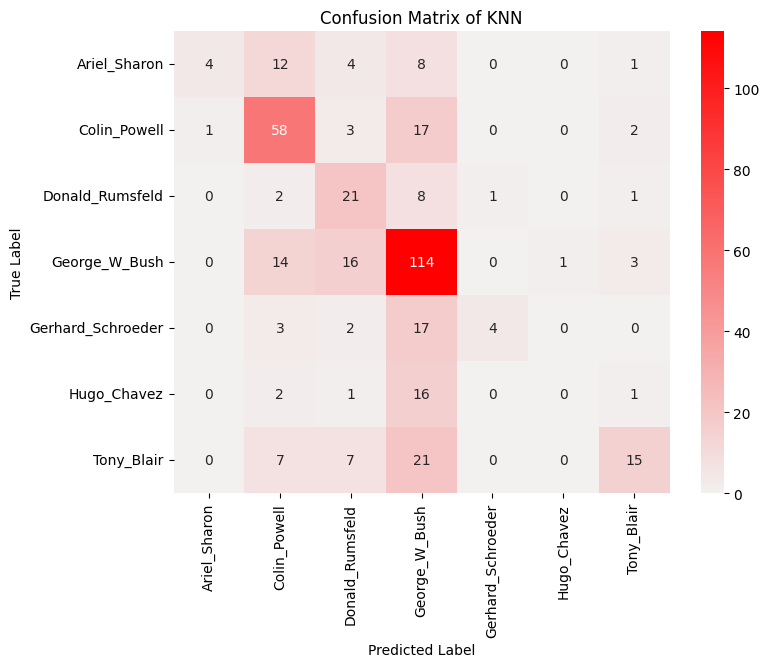

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of KNN')
plt.show()


In [ ]:
nn=grid.best_params_

In [ ]:
from sklearn.metrics import accuracy_score
print("accuracy score whith knn with n_neighbors=",nn['n_neighbors'],"(best case) is:",accuracy_score(y_test, y_pred))

accuracy score whith knn with n_neighbors= 10 (best case) is: 0.5581395348837209


# **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

# Define logistic regression classifier
logistic_regression = LogisticRegression(max_iter=200)

# Define the parameter grid for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Penalty term
}

# Create GridSearchCV object
grid_logistic_regression = GridSearchCV(logistic_regression, param_grid, cv=10, scoring='accuracy', return_train_score=False)

# Fit the model to the training data
grid_logistic_regression.fit(X_train, y_train)



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=200),
             param_grid={'C': [0.001, 0.01, 0.1, 1], 'penalty': ['l1', 'l2']},
             scoring='accuracy')

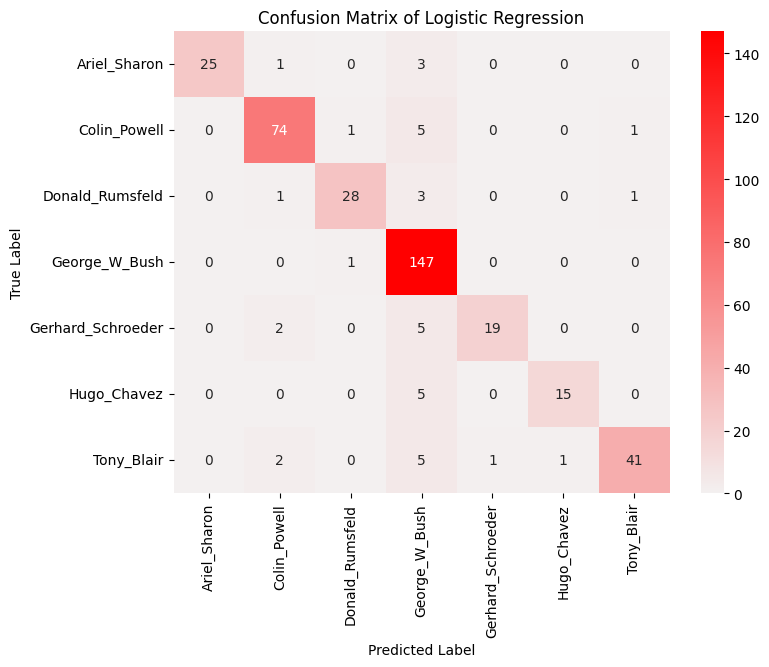

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
y_pred = grid_logistic_regression.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Logistic Regression')
plt.show()


In [ ]:
# Print the best parameters and best score
print("Best parameters found: ", grid_logistic_regression.best_params_)
from sklearn.metrics import accuracy_score
print("Accuracy using best parameter",accuracy_score(y_test,y_pred))


Best parameters found:  {'C': 1, 'penalty': 'l2'}
Accuracy using best parameter 0.9018087855297158


# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=71,max_depth=21,min_samples_split=2,min_samples_leaf=5)
rf_classifier.fit(X_train,y_train)
y_pred_rf = rf_classifier.predict(X_test)

from sklearn.metrics import accuracy_score
print("Accuracy score with RandomForestClassifier , n_estimators=71",accuracy_score(y_test,y_pred_rf))

Accuracy score with RandomForestClassifier , n_estimators=71 0.6356589147286822


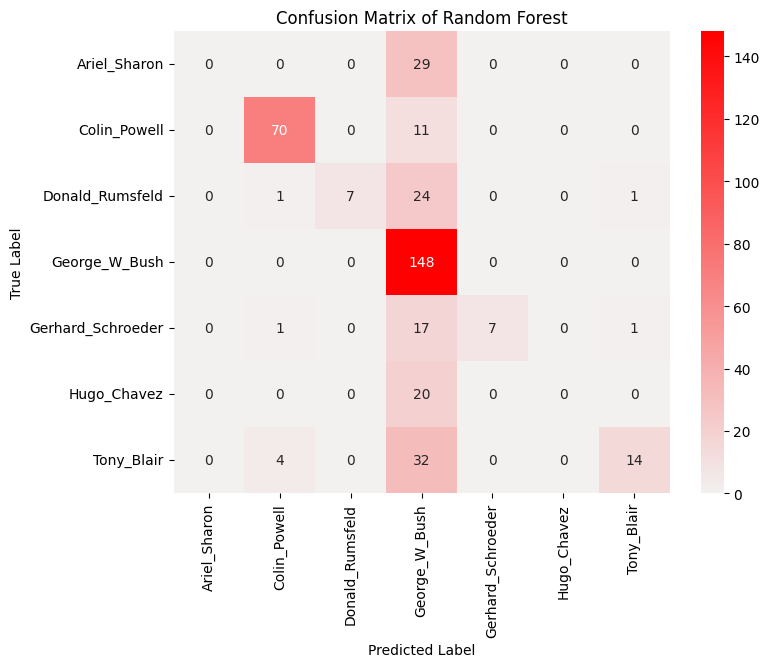

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
#y_pred = rf_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_rf)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Random Forest')
plt.show()


# **Gaussian Naive Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=10)
}
from sklearn.model_selection import GridSearchCV
nbModel_grid = GridSearchCV(gnb, param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_train, y_train)




Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GridSearchCV(cv=10, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])},
             verbose=1)

In [ ]:
y_pred=nbModel_grid.predict(X_test)
print("Accuracy score with Gaussian Naive Bias after implementation of Grid search",accuracy_score(y_test,y_pred))



Accuracy score with Gaussian Naive Bias after implementation of Grid search 0.6950904392764858


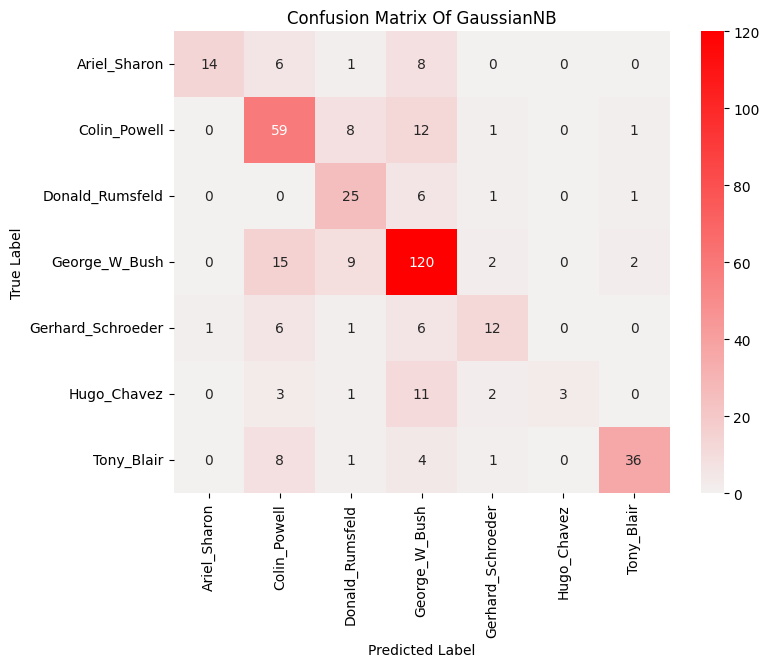

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
#y_pred = gnb.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Of GaussianNB')
plt.show()


# **Linear SVM**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Linear SVM
svm_linear = SVC(kernel='linear',C=1)
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_test)
print("Linear SVM Classification Report:")
print(classification_report(y_test, y_pred_linear))
print(accuracy_score(y_test,y_pred_linear))

Linear SVM Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       1.00      0.86      0.93        29
     Colin_Powell       0.94      0.91      0.92        81
  Donald_Rumsfeld       0.96      0.79      0.87        33
    George_W_Bush       0.83      1.00      0.91       148
Gerhard_Schroeder       0.86      0.73      0.79        26
      Hugo_Chavez       0.92      0.60      0.73        20
       Tony_Blair       1.00      0.84      0.91        50

         accuracy                           0.89       387
        macro avg       0.93      0.82      0.86       387
     weighted avg       0.90      0.89      0.89       387

0.8940568475452196


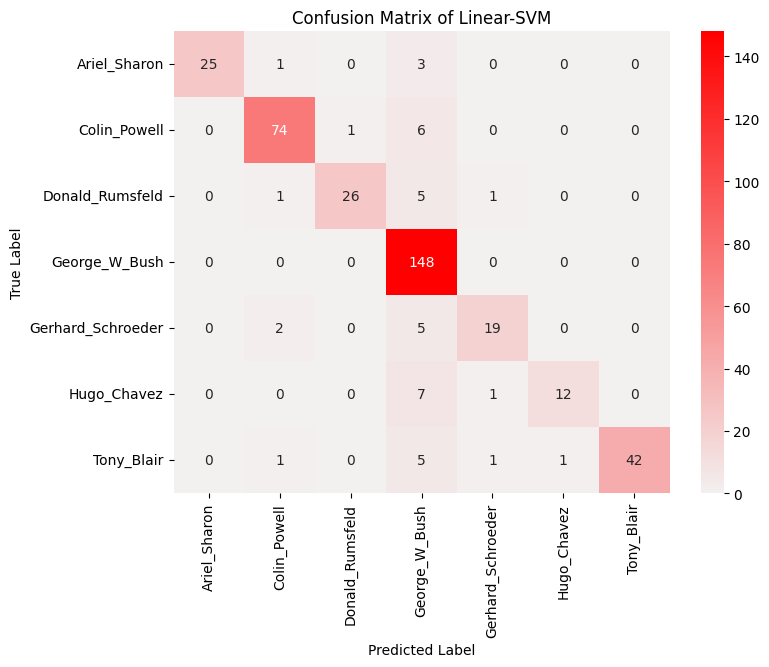

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_linear)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Linear-SVM')
plt.show()


# **Polynomial SVM**

In [ ]:
# Polynomial SVM
svm_poly = SVC(kernel='poly', degree=2,C=1)  # You can adjust the degree parameter as needed
svm_poly.fit(X_train, y_train)
y_pred_poly = svm_poly.predict(X_test)
print("\nPolynomial SVM Classification Report:")
print(classification_report(y_test, y_pred_poly))
print(accuracy_score(y_test,y_pred_poly))



Polynomial SVM Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       1.00      0.72      0.84        29
     Colin_Powell       0.92      0.90      0.91        81
  Donald_Rumsfeld       1.00      0.79      0.88        33
    George_W_Bush       0.76      1.00      0.86       148
Gerhard_Schroeder       1.00      0.62      0.76        26
      Hugo_Chavez       1.00      0.50      0.67        20
       Tony_Blair       1.00      0.78      0.88        50

         accuracy                           0.86       387
        macro avg       0.95      0.76      0.83       387
     weighted avg       0.89      0.86      0.86       387

0.8604651162790697


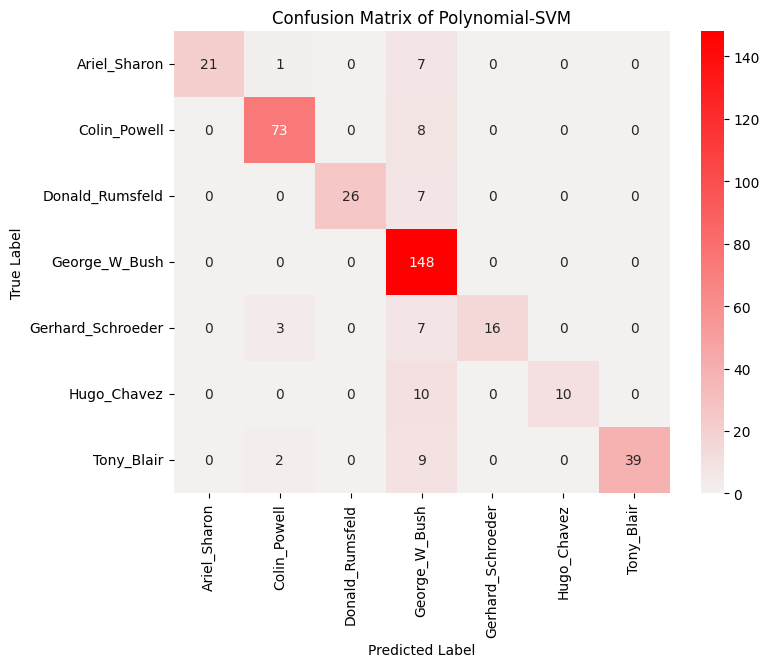

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
#y_pred = gnb.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_poly)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Polynomial-SVM')
plt.show()


# **RBF - SVM**

In [ ]:
# RBF SVM
svm_rbf = SVC(kernel='rbf',C=100,gamma=0.001)
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)
print("\nRBF SVM Classification Report:")
print(classification_report(y_test, y_pred_rbf))
print(accuracy_score(y_test,y_pred_rbf))


RBF SVM Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       1.00      0.21      0.34        29
     Colin_Powell       0.89      0.83      0.86        81
  Donald_Rumsfeld       1.00      0.42      0.60        33
    George_W_Bush       0.58      1.00      0.73       148
Gerhard_Schroeder       1.00      0.31      0.47        26
      Hugo_Chavez       0.00      0.00      0.00        20
       Tony_Blair       1.00      0.54      0.70        50

         accuracy                           0.70       387
        macro avg       0.78      0.47      0.53       387
     weighted avg       0.76      0.70      0.66       387

0.6976744186046512


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


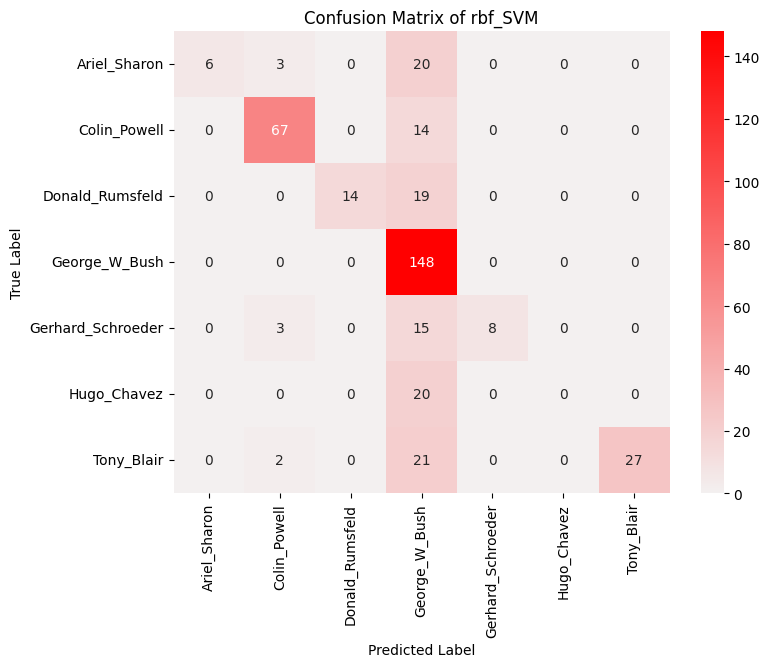

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rbf)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of rbf_SVM')
plt.show()


# **Applying Label Encoder**

In [32]:
from sklearn.preprocessing import LabelEncoder

# Convert class labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [33]:
print(np.unique(y_train_encoded))

[0 1 2 3 4 5 6]


# **MLP (via Sci-Kit Learn)**

In [34]:
from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp_classifier.fit(X_train, y_train_encoded)

# Predict on the test set
y_pred_mlp = mlp_classifier.predict(X_test)

# Convert predictions back to original labels


# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred_mlp)
print("Accuracy using ANN of sklearn", accuracy)


Accuracy using ANN of sklearn 0.8320413436692506


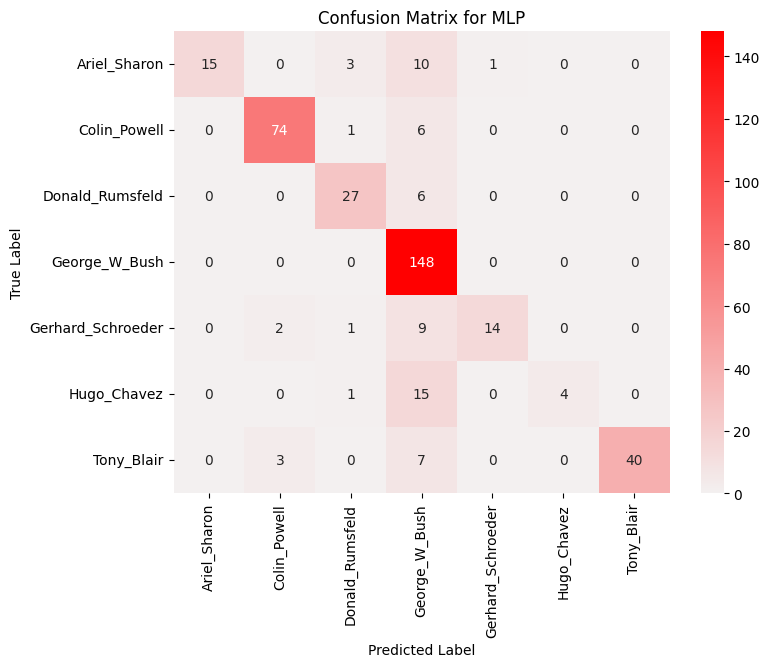

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix

conf_matrix = confusion_matrix(y_test_encoded, y_pred_mlp)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for MLP')
plt.show()


# **MLP (via Tensor Flow - Keras)**

In [36]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_encoded, epochs=15, batch_size=32, verbose=1,validation_split=0.2)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print("Test Accuracy using ANN of tensorflow keras", accuracy)

Epoch 1/15
23/23 [==============================] - 6s 232ms/step - loss: 2.8150 - accuracy: 0.3389 - val_loss: 1.7140 - val_accuracy: 0.3204
Epoch 2/15
23/23 [==============================] - 13s 588ms/step - loss: 1.2908 - accuracy: 0.5569 - val_loss: 1.2711 - val_accuracy: 0.5470
Epoch 3/15
23/23 [==============================] - 5s 213ms/step - loss: 0.7594 - accuracy: 0.7417 - val_loss: 1.0168 - val_accuracy: 0.6575
Epoch 4/15
23/23 [==============================] - 4s 181ms/step - loss: 0.3570 - accuracy: 0.9125 - val_loss: 0.8410 - val_accuracy: 0.7182
Epoch 5/15
23/23 [==============================] - 5s 221ms/step - loss: 0.1436 - accuracy: 0.9833 - val_loss: 0.6191 - val_accuracy: 0.8066
Epoch 6/15
23/23 [==============================] - 4s 188ms/step - loss: 0.0476 - accuracy: 1.0000 - val_loss: 0.6269 - val_accuracy: 0.7790
Epoch 7/15
23/23 [==============================] - 4s 180ms/step - loss: 0.0211 - accuracy: 1.0000 - val_loss: 0.5223 - val_accuracy: 0.8398
Epoch

In [37]:
y_pred_mlpt=model.predict(X_test)

# Find the index of the maximum value along each row
l=[]
for i in range(y_pred_mlpt.shape[0]):

      max_index = np.argmax(y_pred_mlpt[i], axis=0)
      l.append(max_index)

# Reshape max_indices to have shape (387, 1)
l=np.array(l)
y_pred_mlpt = l.reshape(-1,1)

13/13 [==============================] - 1s 28ms/step


In [38]:
y_pred_mlpt.shape

(387, 1)

In [39]:
y_test_encoded.shape

(387,)

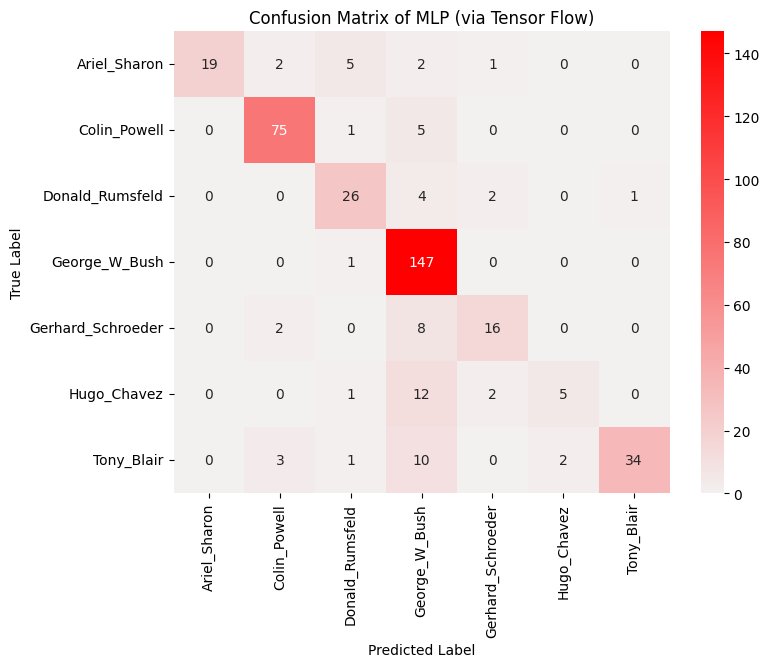

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_mlpt)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of MLP (via Tensor Flow)')
plt.show()
